### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интелекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 7


### Дисциплина: Методы машинного обучения

##### Студент:  Щербак Маргарита Романовна
##### Группа:   НПИбд-02-21

### Вариант №24

1. Набор данных: svhn_cropped

2. Диапазон классов: 1, 3, 5, 7, 9

3. Архитектура автокодировщика: MLP

4. Показатель качества:   
cреднее абсолютное отклонение (MAE) для ошибки реконструкции

5. Показатель качества бинарной классификации:   
индекс Фоулкса – Мэллоуса, равный корню квадратному из TP/(TP + TN) * TP/(TP + FP)

**Задание 1**   
Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).

В моем датасете картинки цветные, поэтому перекодирую их в одноцветные.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, losses, metrics
from PIL import Image, ImageOps


ds = tfds.load("svhn_cropped", split=['train', 'test'])
df_train = tfds.as_dataframe(ds[0])
df_test = tfds.as_dataframe(ds[1])

df_train.shape, df_test.shape

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteJKI57Q/svhn_cropped-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteJKI57Q/svhn_cropped-test.tfrecord*...:   0%| …

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteJKI57Q/svhn_cropped-extra.tfrecord*...:   0%|…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.


((73257, 2), (26032, 2))

In [ ]:
df_train = df_train.loc[df_train['label'].isin([1, 3, 5, 7, 9])]
df_test = df_test.loc[df_test['label'].isin([1, 3, 5, 7, 9])]
df_train['label'] = df_train['label'].map({1:0, 3:1, 5:2, 7:3, 9:4})
df_test['label'] = df_test['label'].map({1:0, 3:1, 5:2, 7:3, 9:4})

df_train.shape, df_test.shape

((39494, 2), (13979, 2))

In [ ]:
df_train['label'].unique(), df_test['label'].unique(), df_train.iloc[0]['image'].shape

(array([3, 1, 2, 0, 4]), array([3, 1, 0, 2, 4]), (32, 32, 3))

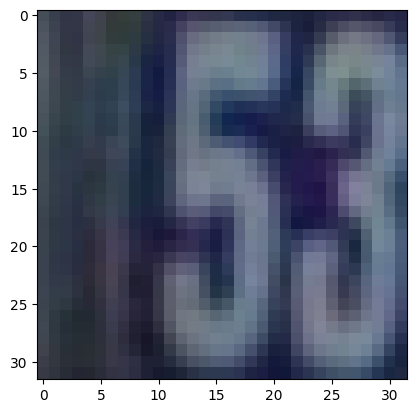

In [ ]:
def display_image(df_train):
  img = Image.fromarray(df_train.iloc[7]['image'])
  plt.imshow(img);

display_image(df_train)

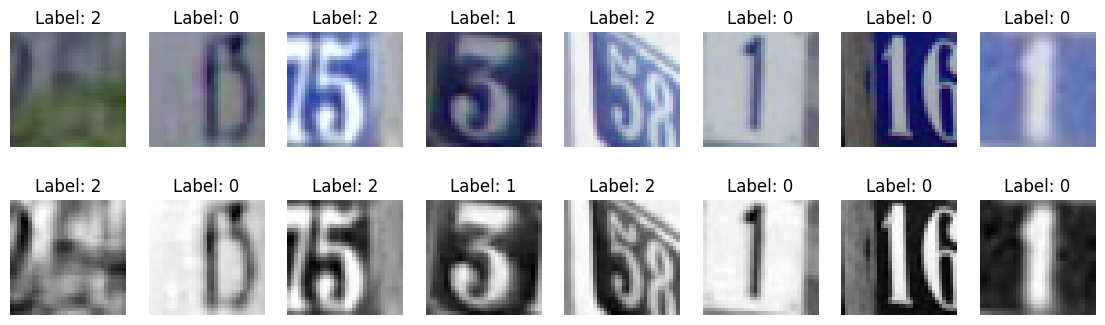

In [ ]:
# Преобразование изображений в оттенки серого
def convert_to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)

def preprocess(df, num_samples=8):
    images, labels = [], []
    df_sample = df.sample(n=num_samples)
    for _, row in df_sample.iterrows():
        images.append(row['image'])
        labels.append(row['label'])
    return np.array(images), np.array(labels)

train_images_color, train_labels_color = preprocess(df_train)

# Преобразование изображений в оттенки серого
train_images_gray = np.array([convert_to_grayscale(image).numpy() for image in train_images_color])

def show_images(images1, images2, labels):
    plt.figure(figsize=(14, 4))
    for i in range(len(images1)):
        plt.subplot(2, len(images1), i + 1)
        plt.imshow(images1[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')

        plt.subplot(2, len(images1), i + 1 + len(images1))
        plt.imshow(images2[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

show_images(train_images_color, train_images_gray, train_labels_color)

**Задание 2**   
Постройте для набора данных график логарифмического правдоподобия профиля в зависимости от числа главных компонент и определите размерность латентного пространства.

In [ ]:
x_train = np.array([image.flatten() for image in df_train['image']])

x_train.shape

(39494, 3072)

In [ ]:
# Фильтрация данных для классов
train_mask = df_train['label'].isin([1, 3, 5, 7, 9])
test_mask = df_test['label'].isin([1, 3, 5, 7, 9])

df_train_filtered = df_train.loc[train_mask].copy()
df_test_filtered = df_test.loc[test_mask].copy()

label_map = {1: 0, 3: 1, 5: 2, 7: 3, 9:4}
df_train_filtered['label'] = df_train_filtered['label'].map(label_map)
df_test_filtered['label'] = df_test_filtered['label'].map(label_map)

train_labels = to_categorical(df_train_filtered['label'], num_classes=5)
test_labels = to_categorical(df_test_filtered['label'], num_classes=5)

train_images = np.zeros(shape=(df_train_filtered.shape[0], 32, 32, 1), dtype=np.float32)
test_images = np.zeros(shape=(df_test_filtered.shape[0], 32, 32, 1), dtype=np.float32)

train_images.shape, test_images.shape

((14092, 32, 32, 1), (4901, 32, 32, 1))

In [ ]:
# Обработка изображений
for idx in range(train_labels.shape[0]):
    image = Image.fromarray(df_train_filtered.iloc[idx]['image'])
    gray_image = ImageOps.grayscale(image).resize((32, 32), Image.LANCZOS)
    train_images[idx, :, :, 0] = np.array(gray_image)

for idx in range(test_labels.shape[0]):
    image = Image.fromarray(df_test_filtered.iloc[idx]['image'])
    gray_image = ImageOps.grayscale(image).resize((32, 32), Image.LANCZOS)
    test_images[idx, :, :, 0] = np.array(gray_image)

print(train_images.shape, test_images.shape)

# Нормализация изображений
train_images /= 255
test_images /= 255

(14092, 32, 32, 1) (4901, 32, 32, 1)


In [ ]:
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

def log_likelihood(evals):
    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)
    for L in range(Lmax):
        group1 = evals[0 : L + 1]
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2

    return ll

n_samples = train_images.shape[0]
X = train_images.reshape(n_samples, -1)

n_images = X.shape[0]
X_train = X[:int(n_images / 2), :]
X_test = X[int(n_images / 2):, :]

X_rank = np.linalg.matrix_rank(X_train)
K_linspace = np.linspace(1, 0.75 * X_rank, 10, dtype=int)
Ks = np.unique(np.append([1, 5, 10, 20], K_linspace))

RMSE_train = np.zeros(len(Ks))
RMSE_test = np.zeros(len(Ks))

for index, K in enumerate(Ks):
    pca = PCA(n_components=K)
    Xtrain_transformed = pca.fit_transform(X_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train[index] = mean_squared_error(X_train, Xtrain_proj, squared=False)
    Xtest_transformed = pca.transform(X_test)
    Xtest_proj = pca.inverse_transform(Xtest_transformed)
    RMSE_test[index] = mean_squared_error(X_test, Xtest_proj, squared=False)

n_samples, n_features = X_train.shape
Kmax = min(n_samples, n_features)

pca = PCA(n_components=Kmax)
X_transformed = pca.fit_transform(X_train)
evals = pca.explained_variance_
ll = log_likelihood(evals)

fraction_var = np.cumsum(evals[0:50] / np.sum(evals))

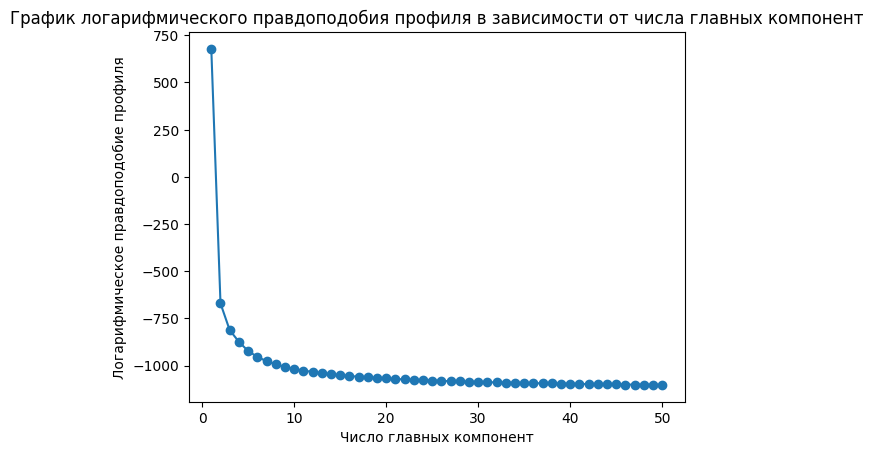

In [ ]:
fig, ax = plt.subplots()
xs = np.arange(1, 51)
ys = ll[0:50]
plt.title("График логарифмического правдоподобия профиля в зависимости от числа главных компонент")
plt.xlabel("Число главных компонент")
plt.ylabel("Логарифмическое правдоподобие профиля")
ax.plot(xs, ys, marker="o")
plt.show()

In [ ]:
# Определение размерности латентного пространства
latent_dim = np.argmax(ll) + 1
print(f"Размерность латентного пространства: {latent_dim}")

Размерность латентного пространства: 1


**Задание 3**   
Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании, с размерностью скрытого представления, равной размерности латентного пространства, определенной в п.2. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений.  

Архитектура автокодировщика: MLP

latent_dim указала другое значение для обучения модели.

In [ ]:
latent_dim = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
input_img = tf.keras.layers.Input(shape=(32 * 32,))

# Encoder
encoded = tf.keras.layers.Dense(512, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(latent_dim, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(32 * 32, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[custom_accuracy])

history = autoencoder.fit(train_images, train_images,
                          epochs=50,
                          batch_size=128,
                          validation_data=(test_images, test_images),
                          callbacks=[callback])


Epoch 1/50
111/111 [==============================] - 8s 51ms/step - loss: 0.6592 - custom_accuracy: 0.4969 - val_loss: 0.6130 - val_custom_accuracy: 0.6383
Epoch 2/50
111/111 [==============================] - 6s 58ms/step - loss: 0.6300 - custom_accuracy: 0.6886 - val_loss: 0.6052 - val_custom_accuracy: 0.7077
Epoch 3/50
111/111 [==============================] - 5s 45ms/step - loss: 0.6257 - custom_accuracy: 0.7374 - val_loss: 0.6031 - val_custom_accuracy: 0.7375
Epoch 4/50
111/111 [==============================] - 7s 62ms/step - loss: 0.6249 - custom_accuracy: 0.7466 - val_loss: 0.6031 - val_custom_accuracy: 0.7374
Epoch 5/50
111/111 [==============================] - 5s 45ms/step - loss: 0.6249 - custom_accuracy: 0.7466 - val_loss: 0.6034 - val_custom_accuracy: 0.7323
Epoch 6/50
111/111 [==============================] - 7s 63ms/step - loss: 0.6236 - custom_accuracy: 0.7605 - val_loss: 0.6015 - val_custom_accuracy: 0.7552
Epoch 7/50
111/111 [==============================] - 5s 4

Визуализировала несколько исходных и восстановленных автокодировщиком изображений.

154/154 [==============================] - 2s 11ms/step


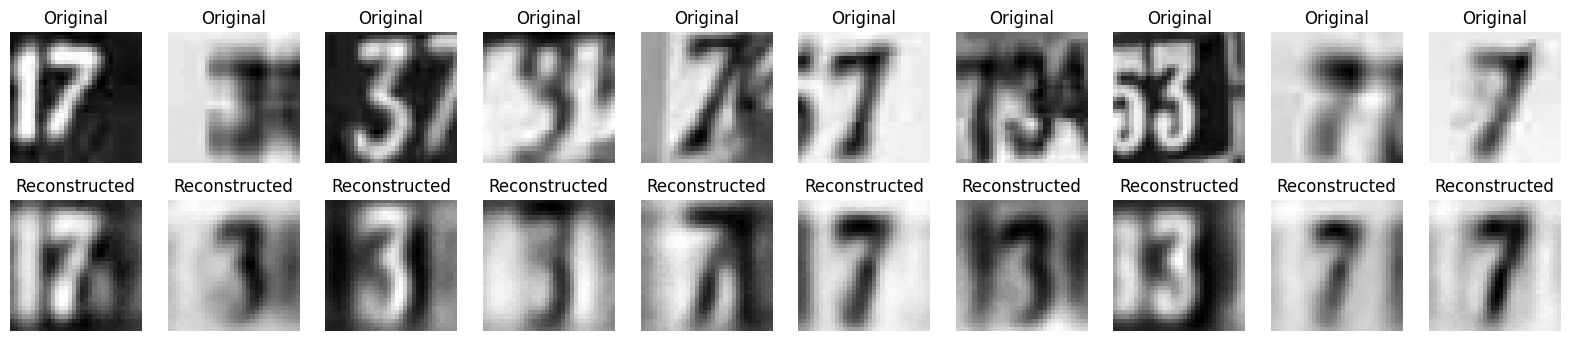

In [ ]:
test_images_flat = test_images.reshape(test_images.shape[0], 32 * 32)
decoded_imgs = autoencoder.predict(test_images_flat)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(32, 32), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

**Задание 4**   
Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Вычисление среднего абсолютного отклонения (MAE)
mae = mean_absolute_error(test_images.flatten(), decoded_imgs.flatten())

print(f'MAE: {mae}')

MAE: 0.04989193379878998


Разница в среднем значений пикселей на изображениях.

**Задание 5**  
Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми. Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

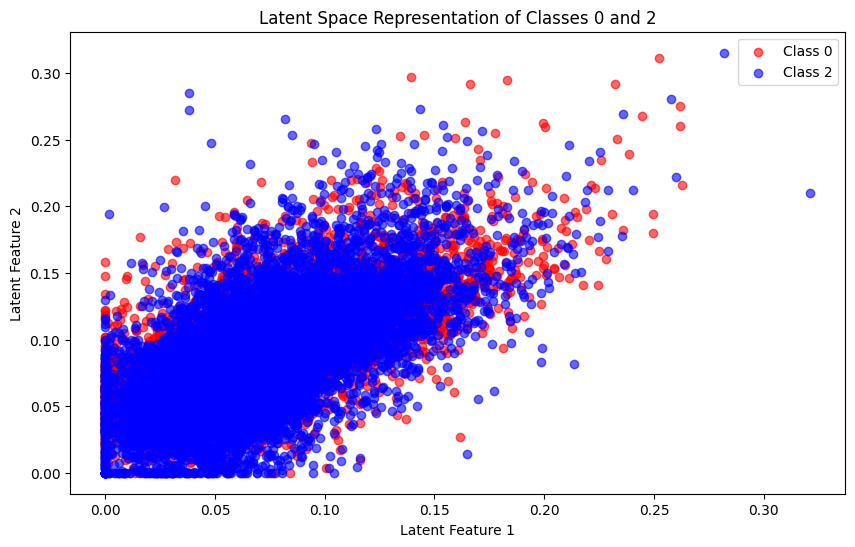

In [ ]:
# Фильтрация данных
train_mask = df_train['label'].isin([1, 3])
test_mask = df_test['label'].isin([1, 3])

df_train_filtered = df_train.loc[train_mask]
df_test_filtered = df_test.loc[test_mask]

label_map = {1: 0, 3: 1}
df_train_filtered.loc[:, 'label'] = df_train_filtered['label'].map(label_map)
df_test_filtered.loc[:, 'label'] = df_test_filtered['label'].map(label_map)
train_labels13 = to_categorical(df_train_filtered['label'], num_classes=2)
test_labels13 = to_categorical(df_test_filtered['label'], num_classes=2)

# Конвертация изображений и меток в numpy массивы
train_images13 = np.zeros(shape=(df_train_filtered.shape[0], 32, 32, 1), dtype=np.float32)
test_images13 = np.zeros(shape=(df_test_filtered.shape[0], 32, 32, 1), dtype=np.float32)

# Изменение размера изображений, преобразование в черно-белые и сохранение в массивы
for idx in range(train_labels13.shape[0]):
    image = Image.fromarray(df_train_filtered.iloc[idx]['image'].astype(np.uint8))
    resized_image = image.resize((32, 32))
    gray_image = ImageOps.grayscale(resized_image)
    train_images13[idx, :, :, 0] = np.array(gray_image)

for idx in range(test_labels13.shape[0]):
    image = Image.fromarray(df_test_filtered.iloc[idx]['image'].astype(np.uint8))
    resized_image = image.resize((32, 32))
    gray_image = ImageOps.grayscale(resized_image)
    test_images13[idx, :, :, 0] = np.array(gray_image)

train_images13 /= 255.0
test_images13 /= 255.0

# Получение латентного представления данных
encoded_train_images = encoder.predict(train_images13)

# Визуализация данных на плоскости
plt.figure(figsize=(8, 6))
colors = ['red', 'blue']
for label in np.unique(latent_labels_original):
    indices = np.where(latent_labels_original == label)
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1], label=f'Class {label}', alpha=0.6, c=colors[label//2])

plt.title("Latent Space Representation of Classes 0 and 2")
plt.xlabel("Latent Feature 1")
plt.ylabel("Latent Feature 2")
plt.legend()
plt.show()

**Задание 6**  
Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените бинарный классификатор, указанный в индивидуальном задании, для двух построенных классификаторов.

формула индекса Фоулкса-Мэлоуса  
$$\sqrt{\frac{TP}{TP + TN} \times \frac{TP}{TP + FP}}$$


In [ ]:
def fowlkes_mallows_index(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    return np.sqrt(TP / (TP + TN) * TP / (TP + FP))

decoded_imgs_train = autoencoder.predict(train_images)
preds_train = (decoded_imgs_train > 0.5).astype('int').argmax(axis=1)
true_labels_train = train_labels.argmax(axis=1)

# Вычисление индекса Фоулкса-Мэллоуса
fmi_train = fowlkes_mallows_index(true_labels_train, preds_train)

print("Fowlkes-Mallows Index using training data:", fmi_train)

441/441 [==============================] - 5s 12ms/step
Fowlkes-Mallows Index using training data: 0.08155305982399932


Значение хоть и невысокое, указывает на то, что модель способна делать какие-то правильные предсказания, но, разумеется, есть место для улучшения.

**Задание 7**  
Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier).

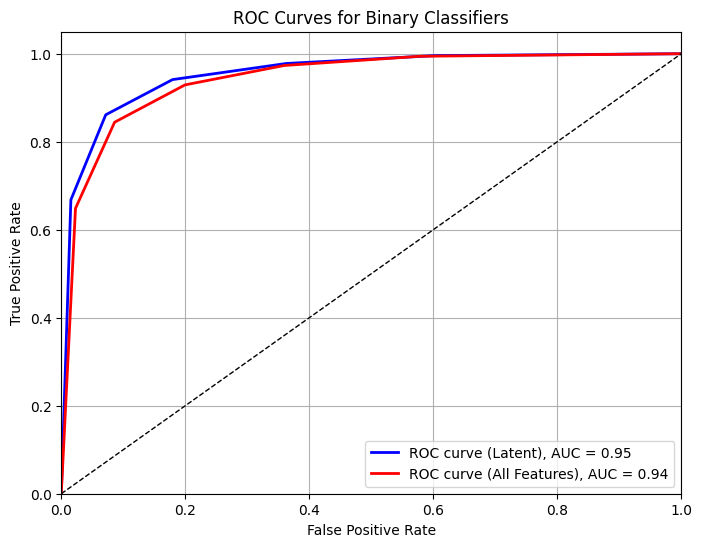

In [ ]:
from sklearn.metrics import roc_curve, auc

y_latent_pred_prob = knn_latent.predict_proba(X_latent_test)[:, 1]
y_all_pred_prob = knn_all.predict_proba(X_test_flatten)[:, 1]
# Вычисление ROC-кривых и площадей под ними
fpr_latent, tpr_latent, _ = roc_curve(y_latent_test, y_latent_pred_prob)
roc_auc_latent = auc(fpr_latent, tpr_latent)
fpr_all, tpr_all, _ = roc_curve(y_test_flatten, y_all_pred_prob)
roc_auc_all = auc(fpr_all, tpr_all)
plt.figure(figsize=(8, 6))
plt.plot(fpr_latent, tpr_latent, color='blue', lw=2, label=f'ROC curve (Latent), AUC = {roc_auc_latent:.2f}')
plt.plot(fpr_all_features, tpr_all_features, color='red', lw=2, label=f'ROC curve (All Features), AUC = {roc_auc_all_features:.2f}')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary Classifiers')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Задание 8**   
Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения).  

In [ ]:
def plot(classifier, X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.reshape(X.shape[0], -1))
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = classifier.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, edgecolor='k')
    plt.title('Decision Boundary for kNN Classifier')
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    plt.show()

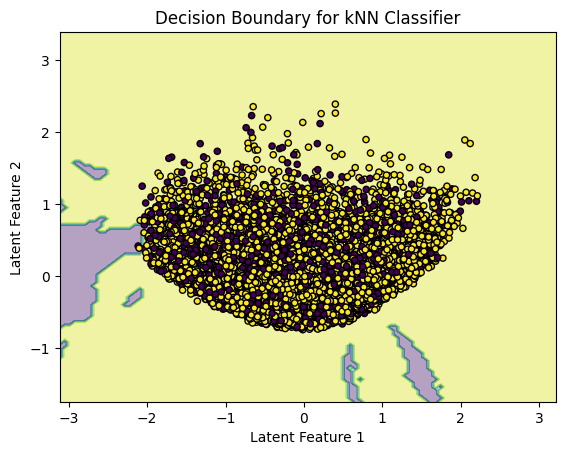

In [ ]:
plot(knn_latent, train_latent_filtered, train_labels_filtered.argmax(axis=1))

**Задание 9**  
Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения.  

154/154 [==============================] - 2s 11ms/step


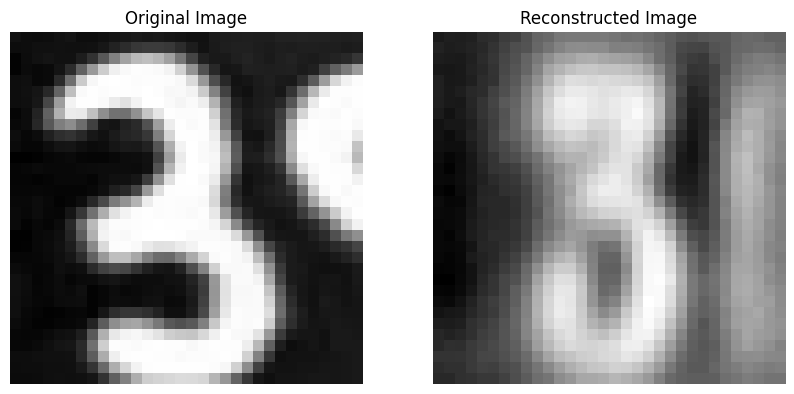

In [ ]:
decoded_imgs = autoencoder.predict(test_images_flat)
reconstruction_errors = np.abs(test_images_flat - decoded_imgs).mean(axis=1)
index_of_max_error = np.argmax(reconstruction_errors)

# Вывести первоначальное и реконструированное изображения с наибольшей ошибкой
original_image = test_images[index_of_max_error]
reconstructed_image = decoded_imgs[index_of_max_error]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image.reshape(32, 32), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.reshape(32, 32), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()